In [1]:
import gymnasium as gym
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import numpy as np
from util import *
import random
# Create the environment with the grayscale observation type
env = gym.make("ALE/Assault-v5", obs_type="grayscale")
obs, info = env.reset()

How objects are extracted

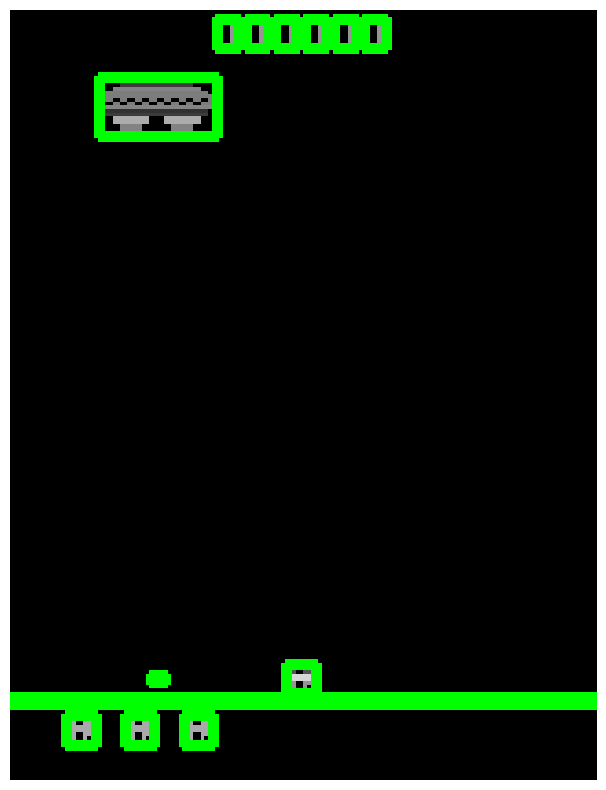

In [2]:
frame = obs  # Replace 'obs' with your grayscale image input
cropped_objects = detect_objects(frame,display=True)

<h1><b>Gotta get this to work before going forward

Get objects between two images.
(Obj1 = detect_objects(frame1))
(Obj2 = detect_objects(frame2))
For each obj_1 in Obj1
    For each obj_2 in Obj2 within window of obj_1
        Get similarity measure (ncc, sad, etc)
    If highest similarity measure > threshold
        two objects correspond (add to transitions)

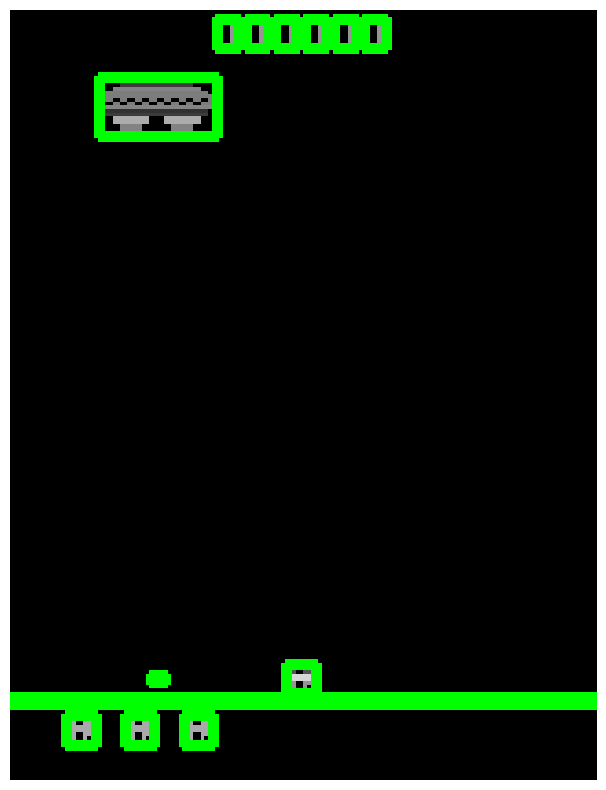

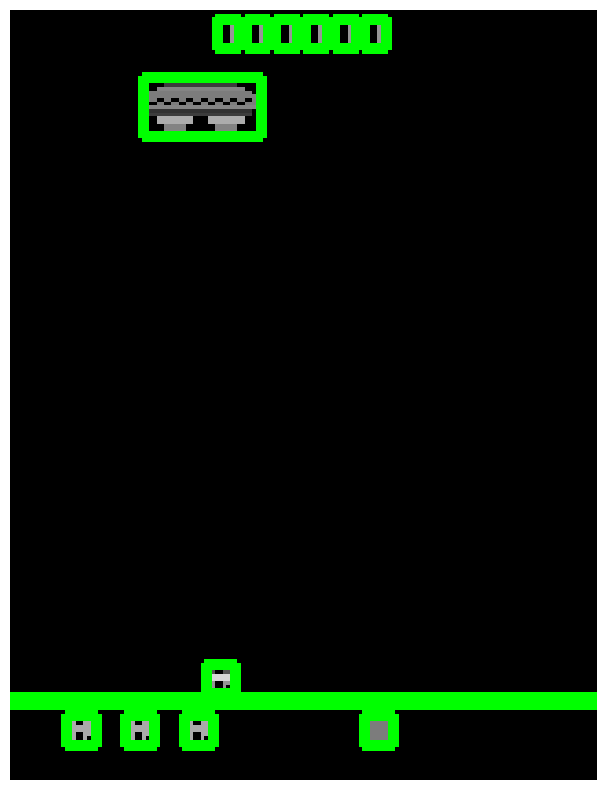

c:\Users\mikef\anaconda3\envs\gym\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mikef\anaconda3\envs\gym\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


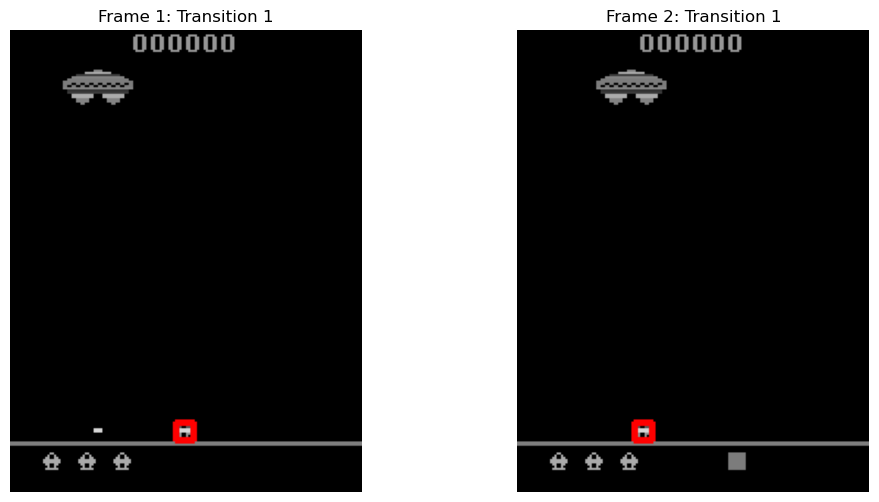

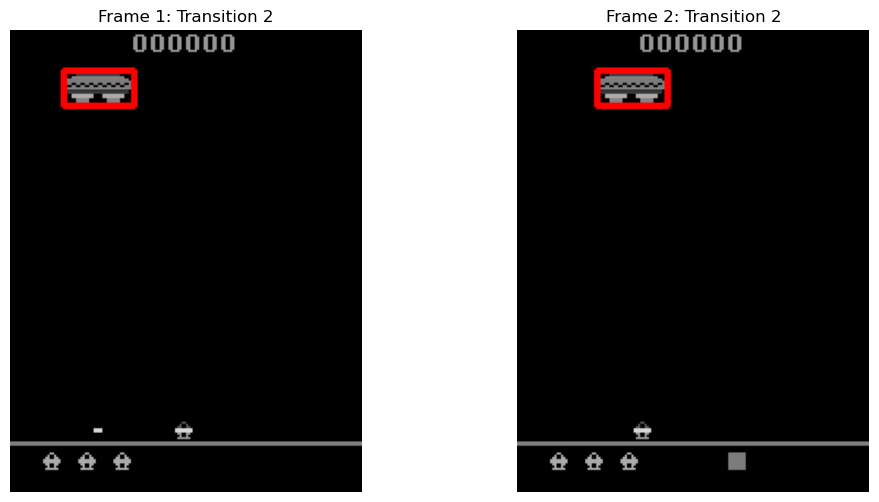

In [3]:
def find_transitions(frame1, frame2, window_size=100, similarity_threshold=0.7, location_similarity_threshold=0.9):
    """
    1) Detect objects in frame1 and frame2
    2) For each object in frame1, find the closest object in frame2 within the window that passes similarity threshold
    3) If closest object is in same location skip it
    4) If closest object is in different location, add it to the transitions list
    5) Return the transitions list
    """
    # Detect objects and bounding boxes in each frame
    objects_frame1 = detect_objects(frame1, display=False)
    objects_frame2 = detect_objects(frame2, display=False)

    # Extract bounding boxes and cropped objects
    bboxes_frame1 = [(bbox, cropped) for cropped, bbox in objects_frame1]
    bboxes_frame2 = [(bbox, cropped) for cropped, bbox in objects_frame2]

    transitions = []
    no_transitions = []

    # Iterate through objects in frame1
    for bbox1, obj1 in bboxes_frame1:
        x1, y1, w1, h1 = bbox1

        # Preliminary check for exact location matches in frame2
        skip = False
        for bbox2, obj2 in bboxes_frame2:
            if bbox1 == bbox2:  # Check if they are in the same location
                # Match dimensions by cropping the intersection area
                min_w, min_h = min(w1, bbox2[2]), min(h1, bbox2[3])
                obj1_cropped = obj1[:min_h, :min_w]
                obj2_cropped = obj2[:min_h, :min_w]

                # Compute normalized cross-correlation (NCC)
                ncc = np.corrcoef(obj1_cropped.flatten(), obj2_cropped.flatten())[0, 1]

                if ncc > location_similarity_threshold:  # If highly similar, skip this object
                    skip = True
                    break
        if skip:
            continue

        # Search for matching objects in frame2 within the window
        best_match = None
        best_similarity = -1

        for bbox2, obj2 in bboxes_frame2:
            x2, y2, w2, h2 = bbox2

            # Ensure bbox2 is within the window around bbox1
            if abs(x1 - x2) > window_size or abs(y1 - y2) > window_size:
                continue

            # Match dimensions by cropping the intersection area
            min_w, min_h = min(w1, w2), min(h1, h2)
            obj1_cropped = obj1[:min_h, :min_w]
            obj2_cropped = obj2[:min_h, :min_w]

            # Compute normalized cross-correlation (NCC)
            ncc = np.corrcoef(obj1_cropped.flatten(), obj2_cropped.flatten())[0, 1]

            if ncc > best_similarity:
                best_similarity = ncc
                best_match = bbox2

        # If best match meets the threshold, it's a transition
        if best_match and best_similarity > similarity_threshold:
            transitions.append((bbox1, best_match))
        else:
            no_transitions.append(bbox1)

    return transitions, no_transitions

frame1, _ = env.reset()
frame2, _,_,_,_ = env.step(4) #move left
frame2, _,_,_,_ = env.step(4)
frame2, _,_,_,_ = env.step(4)
# Detect objects in frame1
objects1 = detect_objects(frame1)
objects2 = detect_objects(frame2)

# Find transitions between frame1 and frame2
transitions, _ = find_transitions(frame1, frame2)

# Visualize the transitions
visualize_transitions(frame1, frame2, transitions)

In [4]:
#Get dataset of episodes where each episode is list of frames
#Want : list of list of frames
episode_frames = []
for i in range(10): 
    init_frame, info = env.reset()
    episode_frame = [init_frame]
    #while not done:
    for _ in range(100):
        action = env.action_space.sample()
        frame, _, done, _, _ = env.step(action)
        episode_frame.append(frame)
        if done:
            break
    episode_frames.append(episode_frame)



In [14]:
#Get transition dataset 
transition_dataset = []
no_transition_dataset = []
for episode in episode_frames:
    for i in range(len(episode)-1):
        transitions, no_transitions = find_transitions(episode[i], episode[i+1], window_size=100, similarity_threshold = 0.1)
        #append frame1, frame2, transition
        transition_dataset.append((episode[i], episode[i+1], transitions))
        no_transition_dataset.append((no_transitions))
        

c:\Users\mikef\anaconda3\envs\gym\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mikef\anaconda3\envs\gym\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [15]:
for i in no_transition_dataset[0]:
    print(i)

(0, 187, 160, 2)
(38, 181, 4, 2)


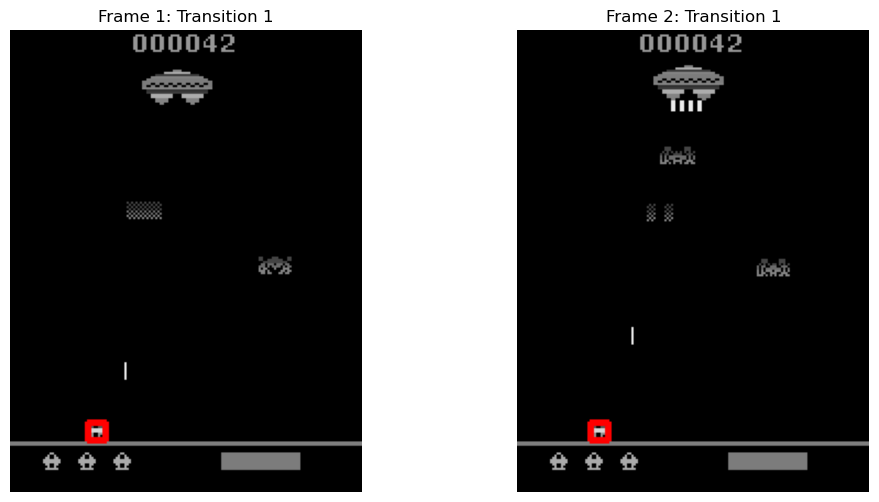

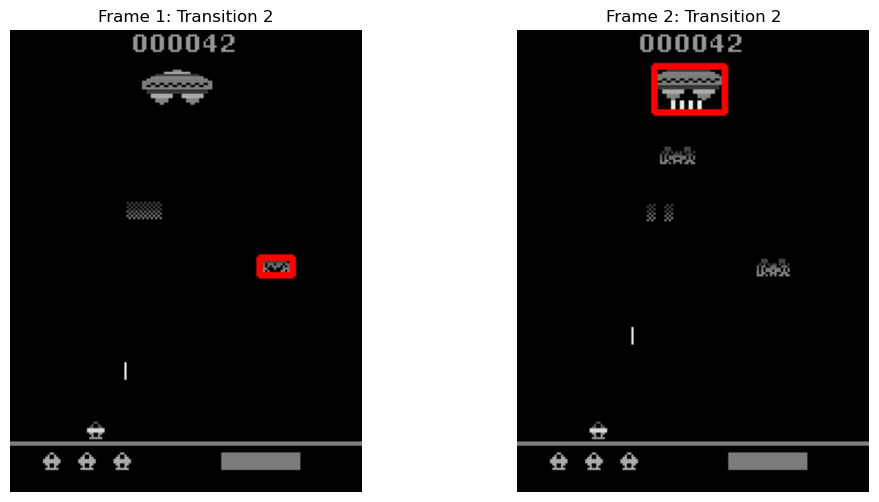

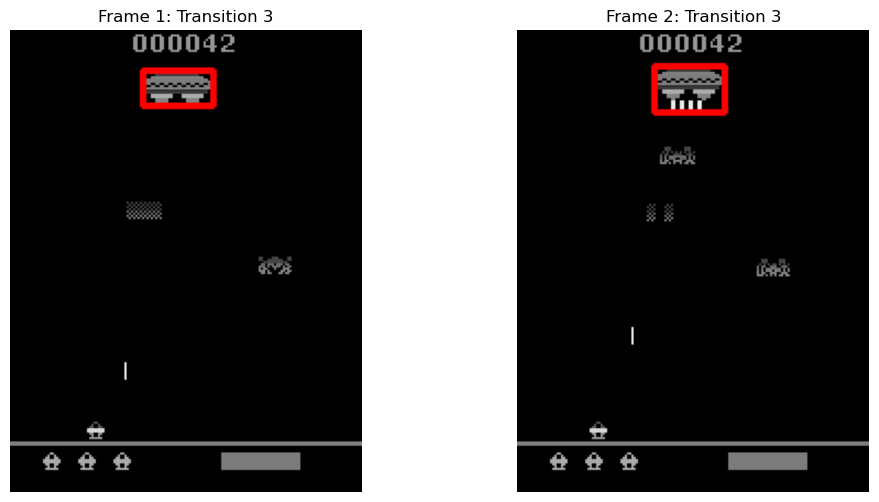

In [19]:
f1,f2,transitions = random.choice(transition_dataset)
visualize_transitions(f1,f2,transitions)

In [20]:
#save f1 and f2
cv2.imwrite('f1.png',f1)
cv2.imwrite('f2.png',f2)

True

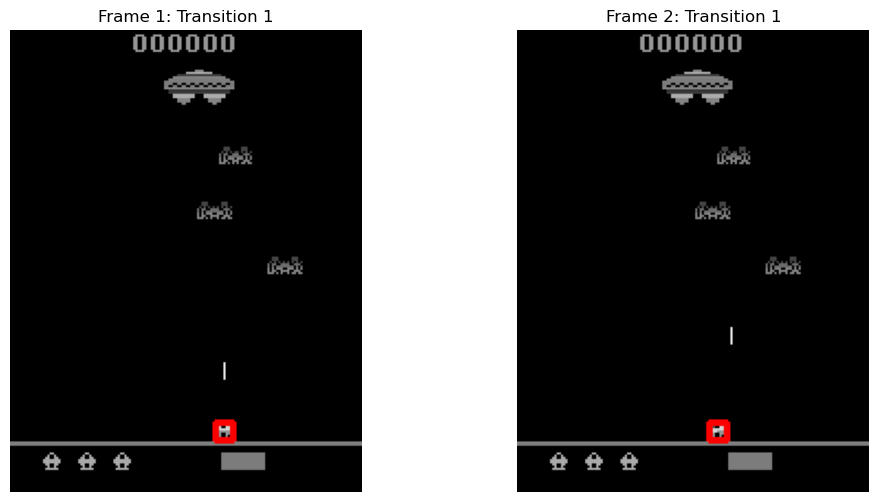

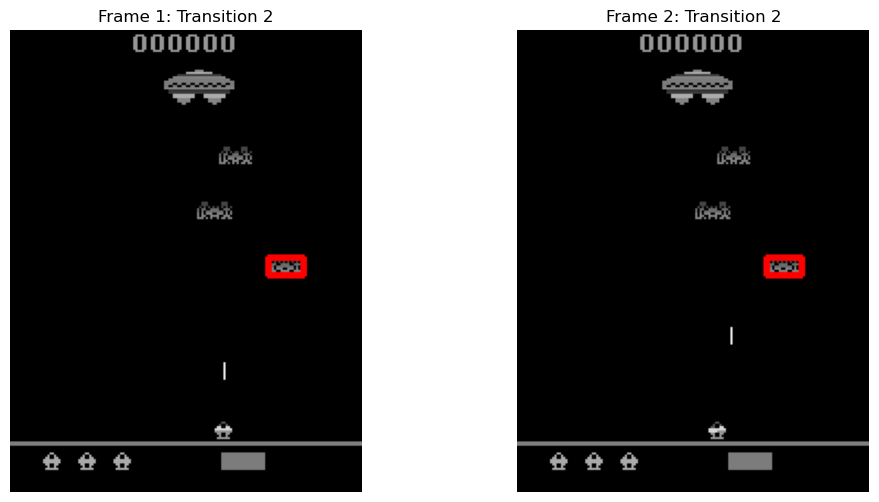

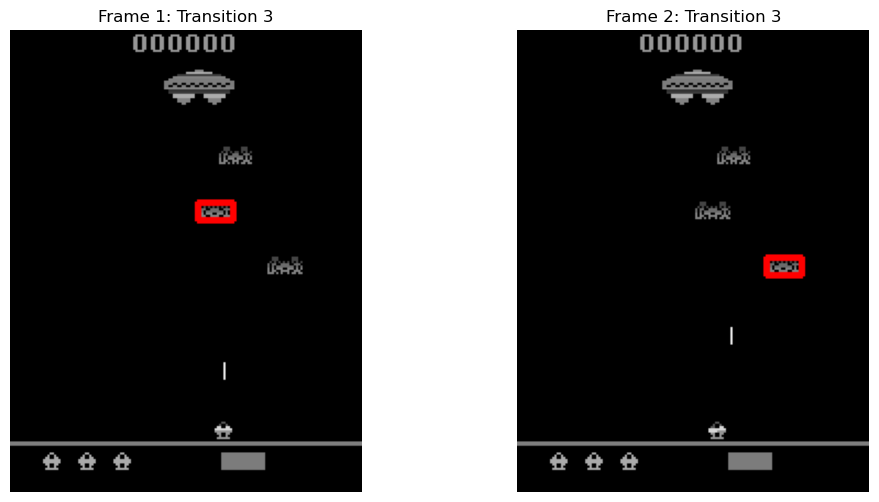

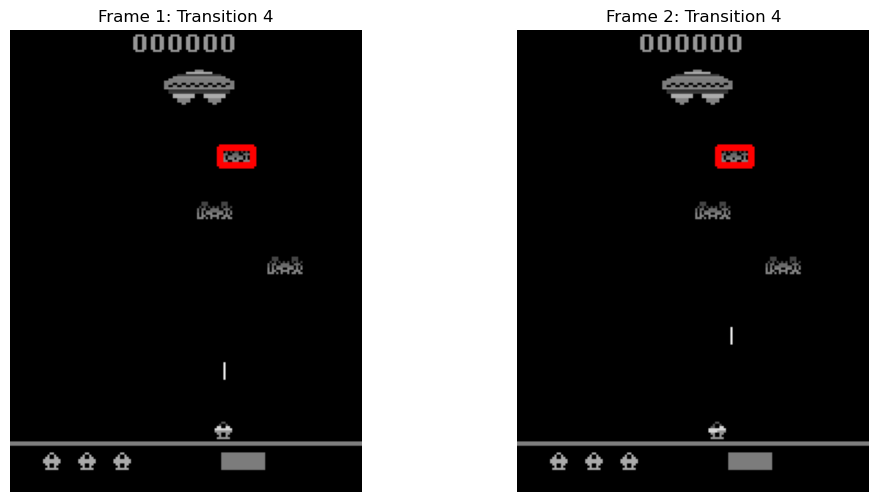

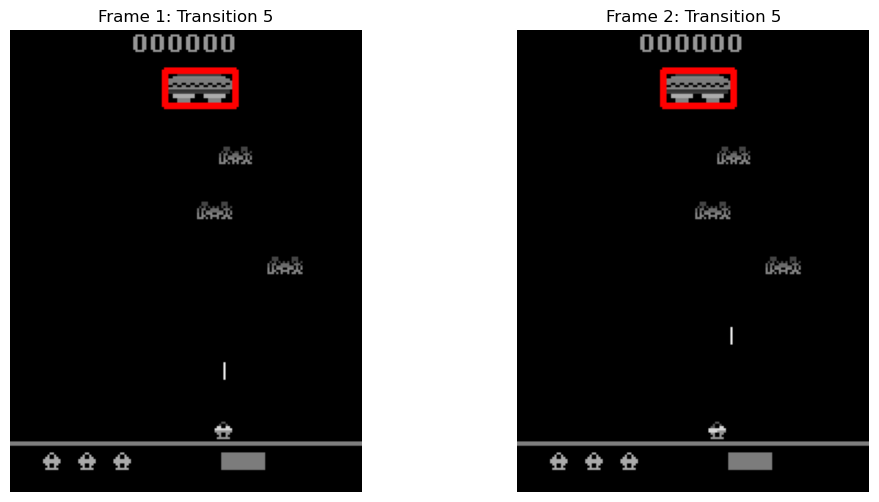

In [8]:
#Visualize transitions
frame_1 = episode_frames[0][45]
frame_2 = episode_frames[0][46]
transitions, _ = find_transitions(frame_1, frame_2)

visualize_transitions(frame_1, frame_2, transitions)



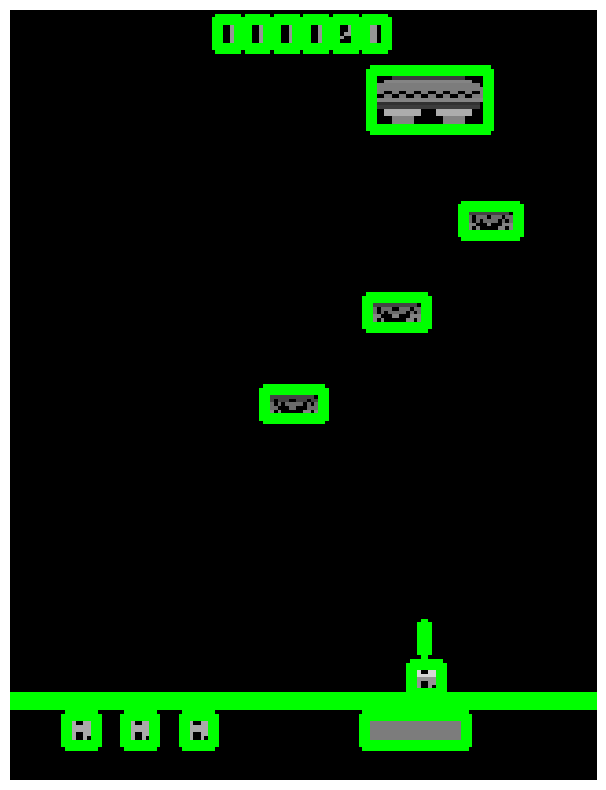

In [11]:
frame_1_objects = detect_objects(frame_1)

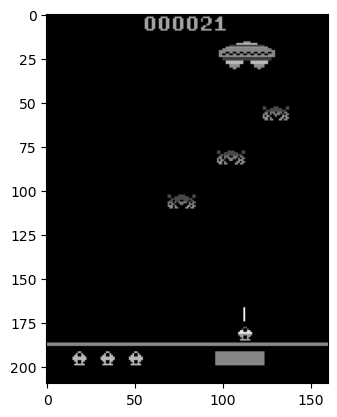

In [22]:
#save frame 1
plt.imshow(frame_1, cmap='gray')

[[124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]
 [124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124]


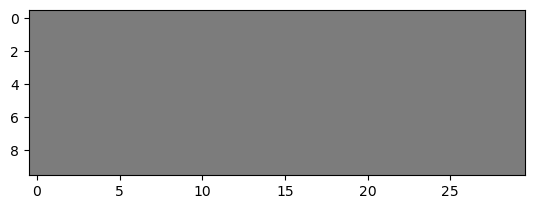

[[ 96  96  96  96  96  96  96  96  96  96]
 [ 96   0   0   0 170 170   0   0   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170 170 170 170 170   0  96]
 [ 96  96  96  96  96  96  96  96  96  96]]


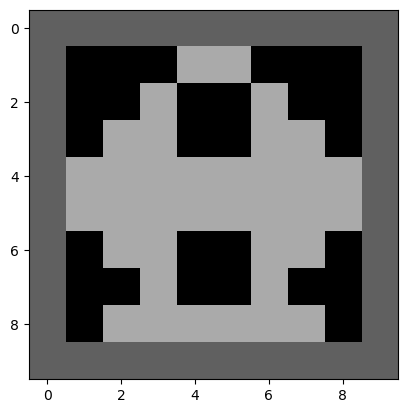

[[ 96  96  96  96  96  96  96  96  96  96]
 [ 96   0   0   0 170 170   0   0   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170 170 170 170 170   0  96]
 [ 96  96  96  96  96  96  96  96  96  96]]


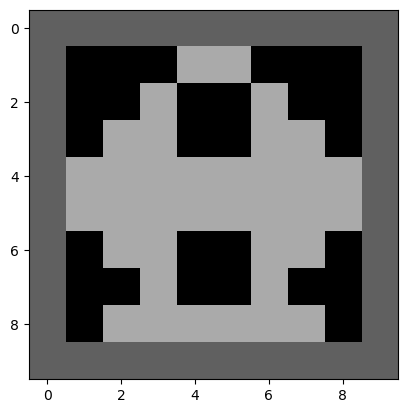

[[ 96  96  96  96  96  96  96  96  96  96]
 [ 96   0   0   0 170 170   0   0   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96 170 170 170 170 170 170 170 170  96]
 [ 96   0 170 170   0   0 170 170   0  96]
 [ 96   0   0 170   0   0 170   0   0  96]
 [ 96   0 170 170 170 170 170 170   0  96]
 [ 96  96  96  96  96  96  96  96  96  96]]


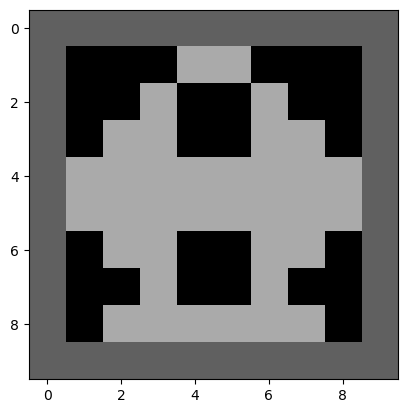

[[127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127]
 [127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127 127
  127 127 127 127 127 127 127 127 127

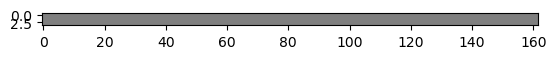

[[ 92  92  92  92  92  92  92  92  92  92]
 [ 92   0   0   0  85  85   0   0   0  92]
 [ 92   0   0  85   0   0  85   0   0  92]
 [ 92   0 214 214   0   0 214 214   0  92]
 [ 92 214 214 214 214 214 214 214 214  92]
 [ 92 148 148 148 148 148 148 148 148  92]
 [ 92   0 148 148   0   0 148 148   0  92]
 [ 92   0   0 148   0   0 148   0   0  92]
 [ 92   0 148 148 148 148 148 148   0  92]
 [ 92  92  92  92  92  92  92  92  92  92]]


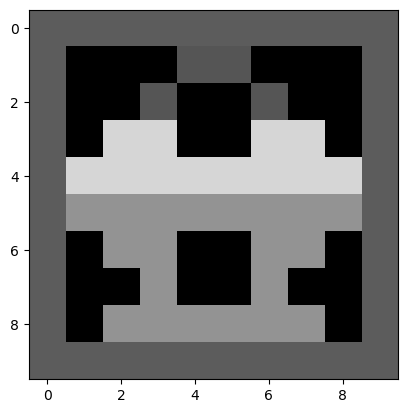

[[236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]
 [236 236 236]]


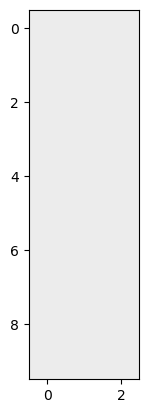

[[ 55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55]
 [ 55  68  68   0   0   0   0  68  68  68  68   0   0   0   0  68  68  55]
 [ 55  68  68   0   0  68  68  68  68  68  68  68  68   0   0  68  68  55]
 [ 55   0   0  68  68  68  68  68  68  68  68  68  68  68  68   0   0  55]
 [ 55   0  68  68   0  68  68  68   0   0  68  68  68   0  68  68   0  55]
 [ 55 107 107 107   0 107   0 107 107 107 107 107   0 107   0 107 107  55]
 [ 55 107   0 107 107   0   0   0 107 107   0   0   0 107 107 107   0  55]
 [ 55 131 131 131   0 131   0   0   0   0   0   0 131 131   0 131 131  55]
 [ 55   0 131 131   0 131 131   0   0   0   0 131 131   0 131 131   0  55]
 [ 55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55  55]]


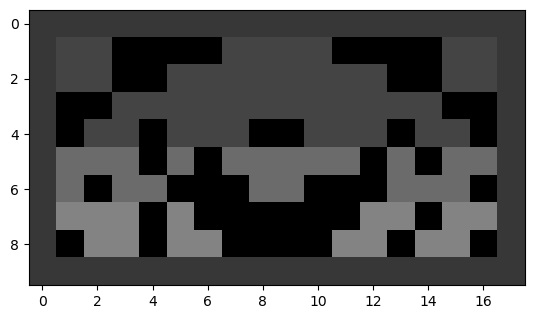

[[ 60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60]
 [ 60  68  68   0   0   0   0  68  68  68  68   0   0   0   0  68  68  60]
 [ 60  68  68   0   0  68  68  68  68  68  68  68  68   0   0  68  68  60]
 [ 60   0   0  68  68  68  68  68  68  68  68  68  68  68  68   0   0  60]
 [ 60   0 107 107   0 107 107 107   0   0 107 107 107   0 107 107   0  60]
 [ 60 107 107 107   0 107   0 107 107 107 107 107   0 107   0 107 107  60]
 [ 60 131   0 131 131   0   0   0 131 131   0   0   0 131 131 131   0  60]
 [ 60 131 131 131   0 131   0   0   0   0   0   0 131 131   0 131 131  60]
 [ 60   0 131 131   0 131 131   0   0   0   0 131 131   0 131 131   0  60]
 [ 60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60]]


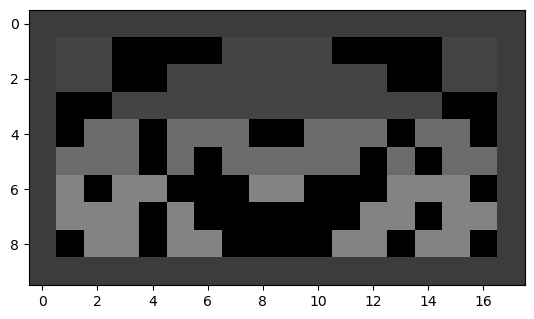

[[ 60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60]
 [ 60  68  68   0   0   0   0  68  68  68   0   0   0   0  68  68  60]
 [ 60  68  68   0   0  68  68  68  68  68  68  68   0   0  68  68  60]
 [ 60   0   0  68  68  68  68  68  68  68  68  68  68  68   0   0  60]
 [ 60   0 107 107   0 107 107 107   0 107 107 107   0 107 107   0  60]
 [ 60 107 107 107   0 107   0 107 107 107 107   0 107   0 107 107  60]
 [ 60 131   0 131 131   0   0   0 131   0   0   0 131 131 131   0  60]
 [ 60 131 131 131   0 131   0   0   0   0   0 131 131   0 131 131  60]
 [ 60   0 131 131   0 131 131   0   0   0 131 131   0 131 131   0  60]
 [ 60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60]]


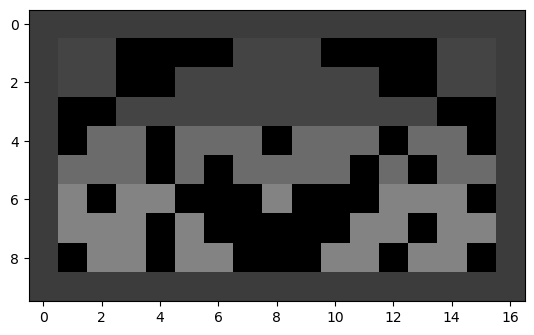

[[ 72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72
   72  72  72  72  72  72  72  72  72  72  72  72  72  72  72  72]
 [ 72   0   0   0   0   0   0   0   0   0   0   0   0   0   0 131 131 131
  131   0   0   0   0   0   0   0   0   0   0   0   0   0   0  72]
 [ 72   0   0   0   0   0   0   0   0   0   0 172 172 172 172 172 172 172
  172 172 172 172 172   0   0   0   0   0   0   0   0   0   0  72]
 [ 72   0   0   0   0   0   0  60  60  60  60  60  60  60  60  60  60  60
   60  60  60  60  60  60  60  60  60   0   0   0   0   0   0  72]
 [ 72   0   0   0   0 132 132 132 132 132 132 132 132 132 132 132 132 132
  132 132 132 132 132 132 132 132 132 132 132   0   0   0   0  72]
 [ 72   0   0 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124 124   0   0  72]
 [ 72 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
  124 124 124 124 124 124 124 124 124 124 124 124 124 124 124  72]
 [ 72 124 124

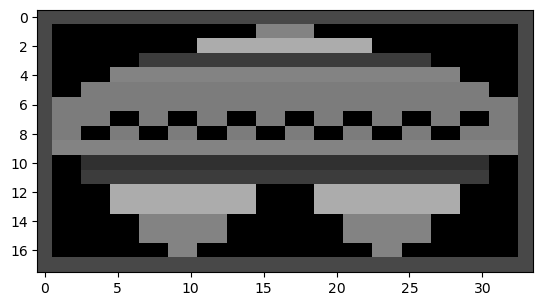

[[ 72  72  72  72  72  72  72  72]
 [ 72   0   0 150 150   0   0  72]
 [ 72   0 150 150 150   0   0  72]
 [ 72 150 150 150 150   0   0  72]
 [ 72   0   0 150 150   0   0  72]
 [ 72   0   0 150 150   0   0  72]
 [ 72   0   0 150 150   0   0  72]
 [ 72   0   0 150 150   0   0  72]
 [ 72 150 150 150 150 150 150  72]
 [ 72  72  72  72  72  72  72  72]]


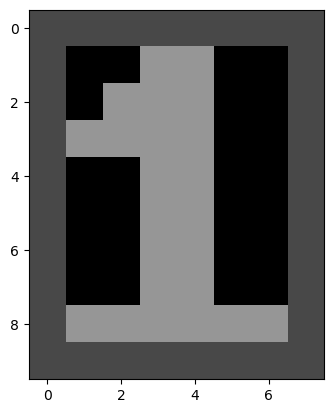

[[ 75  75  75  75  75  75  75  75]
 [ 75   0 150 150 150 150   0  75]
 [ 75 150   0   0   0 150 150  75]
 [ 75 150   0   0   0 150 150  75]
 [ 75   0   0   0   0 150 150  75]
 [ 75   0   0   0 150 150   0  75]
 [ 75   0 150 150   0   0   0  75]
 [ 75 150 150   0   0   0   0  75]
 [ 75 150 150 150 150 150 150  75]
 [ 75  75  75  75  75  75  75  75]]


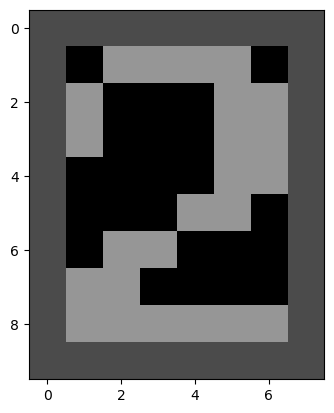

[[100 100 100 100 100 100 100 100]
 [100   0 150 150 150 150   0 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100   0 150 150 150 150   0 100]
 [100 100 100 100 100 100 100 100]]


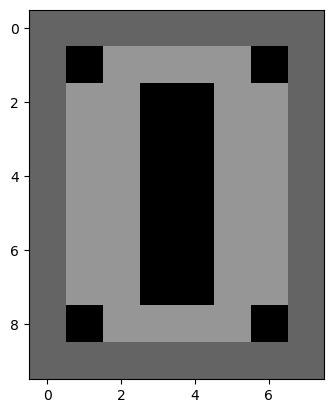

[[100 100 100 100 100 100 100 100]
 [100   0 150 150 150 150   0 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100   0 150 150 150 150   0 100]
 [100 100 100 100 100 100 100 100]]


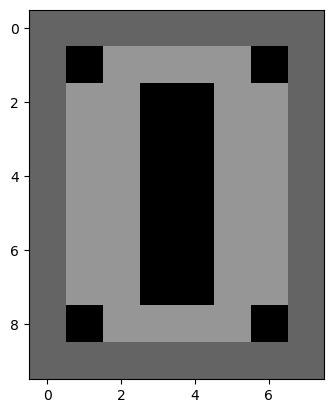

[[100 100 100 100 100 100 100 100]
 [100   0 150 150 150 150   0 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100   0 150 150 150 150   0 100]
 [100 100 100 100 100 100 100 100]]


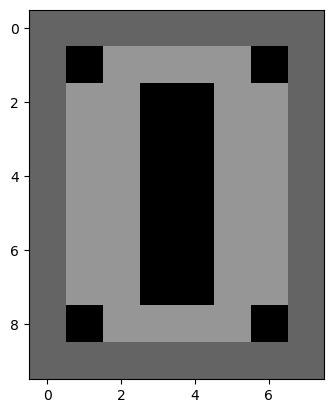

[[100 100 100 100 100 100 100 100]
 [100   0 150 150 150 150   0 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100 150 150   0   0 150 150 100]
 [100   0 150 150 150 150   0 100]
 [100 100 100 100 100 100 100 100]]


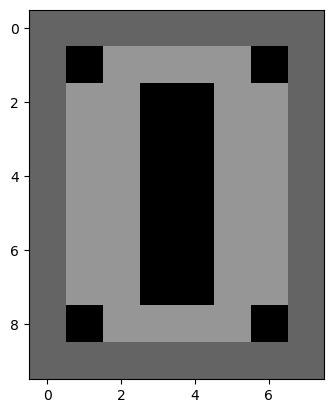

In [28]:
#visualize each object
for i in frame_1_objects:
    #add zero padding
    cropped = i[0]
    x,y,w,h = i[1]
    cropped = cv2.copyMakeBorder(cropped, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=cropped.mean())
    print(cropped)
    plt.imshow(cropped, cmap='gray',vmin=0, vmax=255)
    plt.show()
